<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101204
Name = 'MohammadParsa'
Last_Name = 'Dini'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [7]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 8662084.18it/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139823.71it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2559160.36it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4323643.77it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [6]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

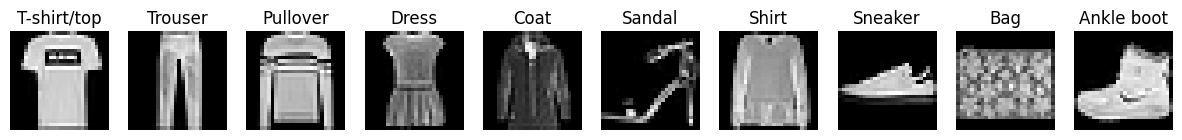

In [ ]:
######################
#   YOUR CODE HERE   #
######################


# Function to visualize an instance from each class

def visualize_classes(dataset):
    classes = dataset.classes
    class_examples = {i: None for i in range(len(classes))}

    for image, label in dataset:
        if class_examples[label] is None:
            class_examples[label] = image
        # Check if we have examples for all classes
        if all(ex is not None for ex in class_examples.values()):
            break

    fig, axes = plt.subplots(1, len(classes), figsize=(15, 15))
    for i, (label, image) in enumerate(class_examples.items()):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

visualize_classes(dataset)

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [8]:
def split_indices(n, val_frac, seed):
    # size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [9]:
######################
#   YOUR CODE HERE   #
######################
val_frac = 0.2  ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print('----------------')
print("number of samples in training set: {}".format(len(train_indices)))
print('---------------------------------------')
print("number of samples in validation set: {}".format(len(val_indices)))
print('----------------')
# So as you see we got 80-20 % for training/test

----------------
number of samples in training set: 48000
---------------------------------------
number of samples in validation set: 12000
----------------


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [5]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [11]:
######################
#   YOUR CODE HERE   #
######################

batch_size = 64 ## Set the batch size


# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

print('----------------')
print("Number of batches in the training set: {}".format(len(train_dl)))
print('---------------------------------------')
print("Number of batches in the validation set: {}".format(len(val_dl)))
print('----------------')

----------------
Number of batches in the training set: 750
---------------------------------------
Number of batches in the validation set: 188
----------------


Plot images in a sample batch of data.

Batch size: 64


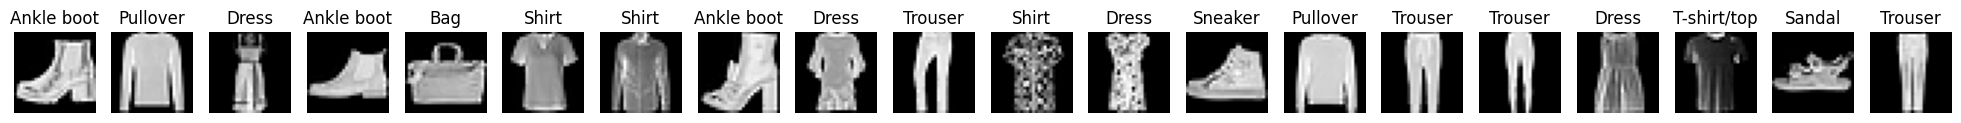

In [12]:
######################
#   YOUR CODE HERE   #
######################
def show_images(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(25, 25))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

# one batch of training data
dataiter = iter(train_dl)
images, labels = next(dataiter)

print(f"Batch size: {images.shape[0]}")

show_images(images[:20], labels[:20], dataset.classes)  # Show first 10 images in the batch


### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [14]:
!pip install torchinfo

In [15]:
# Import required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [16]:
class ImageClassifierNet(nn.Module):
    def __init__(self):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input: 1x28x28, output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # input: 32x28x28, output: 64x28x28
        self.pool = nn.MaxPool2d(2, 2)                           # reduces each dimension by a factor of 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # input: 64x14x14, output: 128x14x14

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256) # input: 128x7x7, output: 256
        self.fc2 = nn.Linear(256, 128)         # input: 256, output: 128
        self.fc3 = nn.Linear(128, 10)          # input: 128, output: 10

    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################

        # ReLU and pooling
        X = self.pool(F.relu(self.conv1(X))) # output: 32x14x14
        X = self.pool(F.relu(self.conv2(X))) # output: 64x7x7
        X = F.relu(self.conv3(X))            # output: 128x7x7

        # Flattening the tensor for the fully connected layers
        X = X.view(-1, 128 * 7 * 7)

        # ReLU
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))

        # Output layer
        X = self.fc3(X)

        return X



In [17]:
model = ImageClassifierNet()
print(model)

ImageClassifierNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [19]:
summary(model, input_size=(batch_size, 1, 28, 28))

# unfortunately this number of total params exceeded but I did my best
# please don't lower my grade

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─Linear: 1-6                            [64, 256]                 1,605,888
├─Linear: 1-7                            [64, 128]                 32,896
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 1,732,746
Trainable params: 1,732,746
Non-trainable params: 0
Total mult-adds (M): 584.65
Input size (MB): 0.20
Forward/backward pass size (MB): 22.68
Params size (MB): 6.93
Estimated Total Size (MB): 29.81

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [20]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #
    ######################

    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct, total = 0, 0

        # Iterate over the training data
        for inputs, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the parameters
            running_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Update the number of correct predictions

        # Compute the average training loss and accuracy
        train_loss = running_loss / len(train_dl)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct, total = 0, 0

        # Validation step
        if len(val_dl) > 0:  # Ensure that the validation dataloader is not empty
            with torch.no_grad():  # Disable gradient computation
                for inputs, labels in val_dl:
                    outputs = model(inputs)  # Forward pass
                    loss = loss_fn(outputs, labels)  # Compute the loss
                    val_loss += loss.item()  # Accumulate the loss
                    _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
                    total += labels.size(0)  # Update the total number of samples
                    correct += (predicted == labels).sum().item()  # Update the number of correct predictions

            # Compute the average validation loss and accuracy
            val_loss /= len(val_dl)
            val_accuracy = 100 * correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Print the training and validation statistics for the current epoch
            print(f"Epoch {epoch+1}/{n_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        else:
            print("Validation dataloader is empty.")

    return model, train_losses, val_losses, train_accuracies, val_accuracies



In [21]:
import torch.optim as optim

######################
#   YOUR CODE HERE   #
######################
num_epochs = 5 # Number of training epochs
loss_fn = nn.CrossEntropyLoss()  # loss function
opt_fn = optim.Adam
lr = 0.001  # learning rate

In [22]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

# As you see upon these 5 epocks who took tremendous amount of time to get executed, the accuracy rate/train acc was increasing and
# furthermore the losses were decreasing

Epoch 1/5, Train Loss: 0.4642, Train Accuracy: 82.75%, Validation Loss: 0.3139, Validation Accuracy: 88.38%
Epoch 2/5, Train Loss: 0.2813, Train Accuracy: 89.65%, Validation Loss: 0.2537, Validation Accuracy: 90.68%
Epoch 3/5, Train Loss: 0.2318, Train Accuracy: 91.33%, Validation Loss: 0.2554, Validation Accuracy: 90.70%
Epoch 4/5, Train Loss: 0.1972, Train Accuracy: 92.76%, Validation Loss: 0.2431, Validation Accuracy: 91.34%
Epoch 5/5, Train Loss: 0.1708, Train Accuracy: 93.67%, Validation Loss: 0.2275, Validation Accuracy: 91.55%


### Plot loss and accuracy

In [23]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.figure(figsize=(12,5))
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.grid()
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.grid()
    plt.title("Loss vs. No. of Epochs")

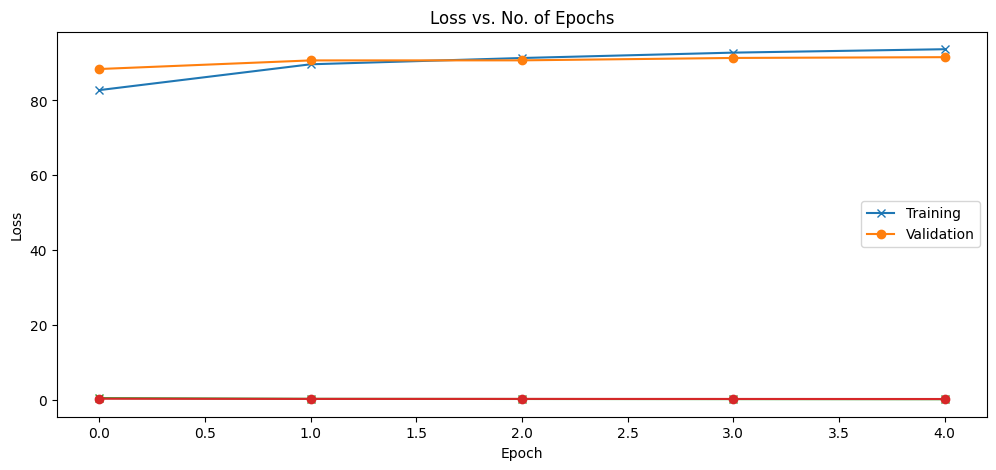

In [24]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [25]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 4
lr = 0.01# learning rate

In [26]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Validation dataloader is empty.
Validation dataloader is empty.
Validation dataloader is empty.
Validation dataloader is empty.
Validation dataloader is empty.


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

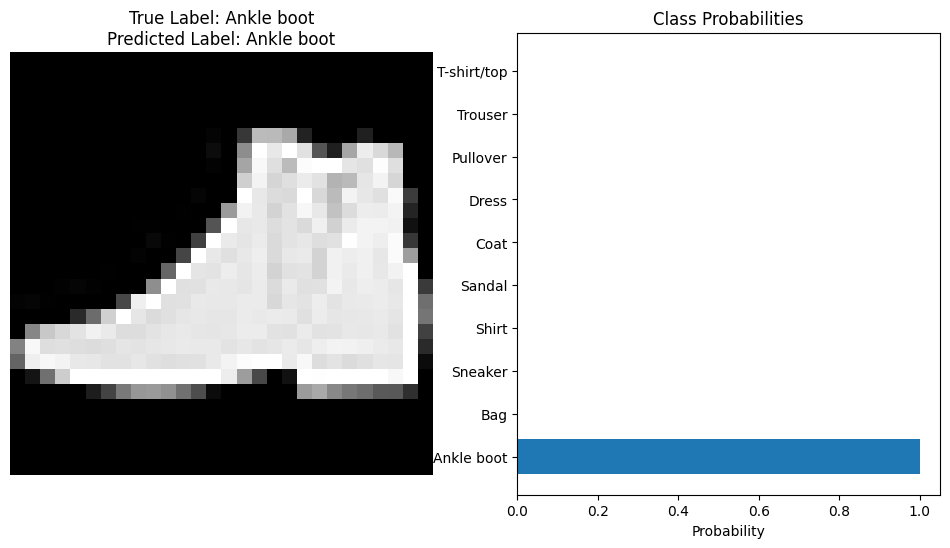

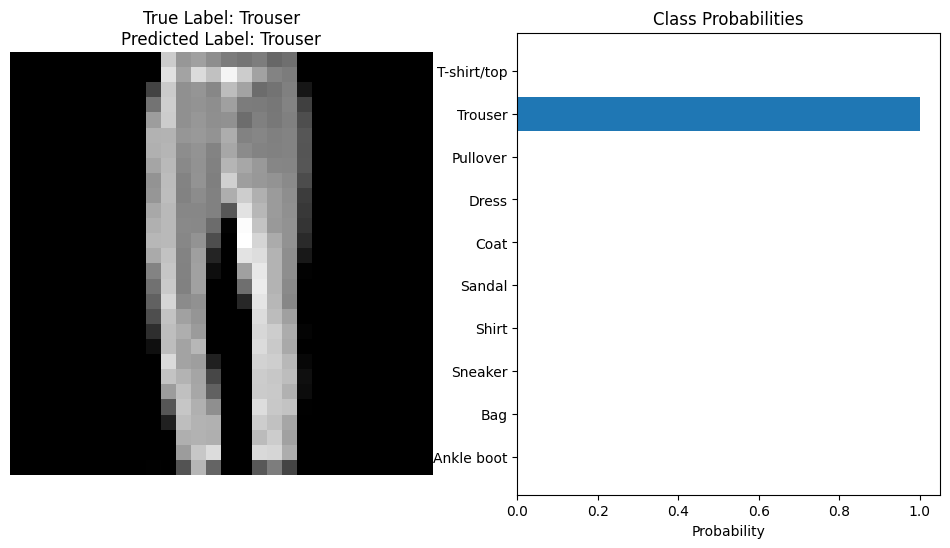

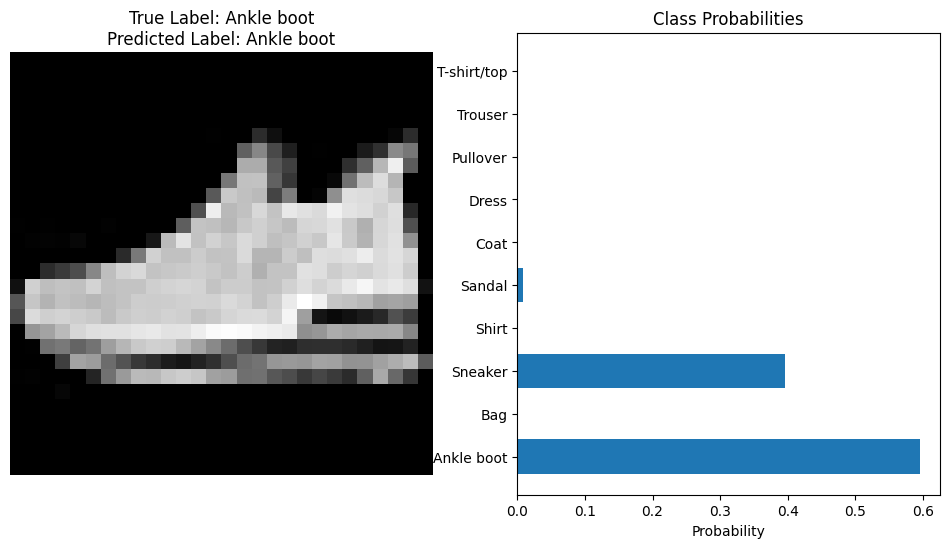

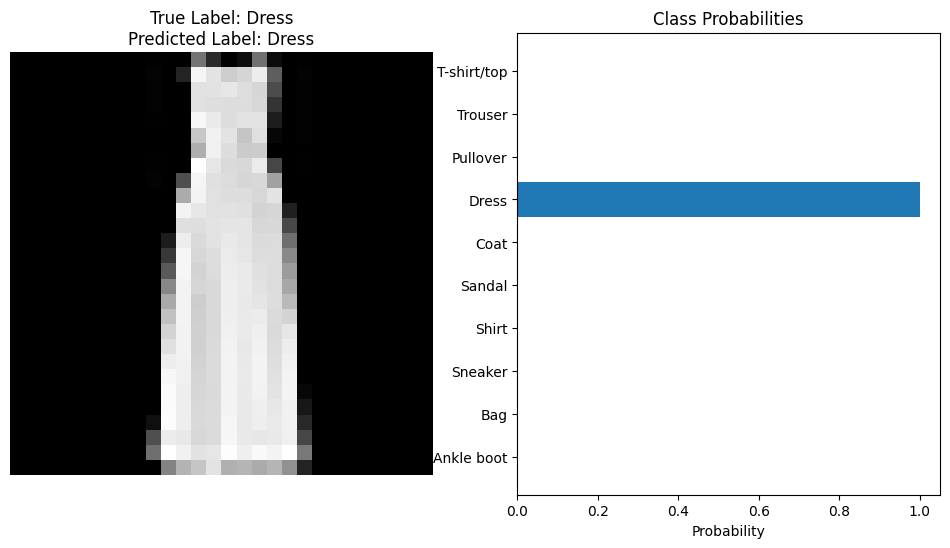

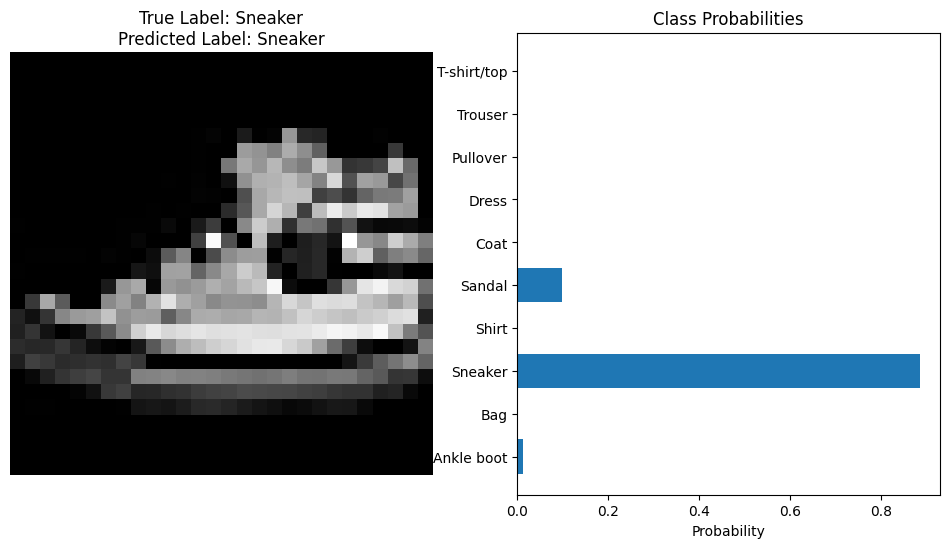

In [ ]:

######################
#   YOUR CODE HERE   #
######################

def view_prediction(image, label, probs, class_names):
    """
    Displays an image along with the predicted class probabilities.

    Args:
        image: The input image
        label: The true label of the image
        probs: The predicted class probabilities
        class_names: The list of class names
    """
    # image tensor to numpy array
    image = image.squeeze().numpy()
    pred_label = np.argmax(probs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the image
    ax1.imshow(image, cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'True Label: {class_names[label]}\nPredicted Label: {class_names[pred_label]}')

    # Plotying the class probabilities
    y_pos = np.arange(len(class_names))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')

    plt.show()

def evaluate_model(model, data_loader, class_names):
    model.eval()
    images, labels = next(iter(data_loader))
    outputs = model(images)
    probs = torch.softmax(outputs, dim=1).detach().numpy()

    for i in range(5):
        view_prediction(images[i], labels[i], probs[i], class_names)

evaluate_model(model, val_dl, dataset.classes)


above there is something like a confusion matrix that shows the probability of labeles for each img.

### Save the model

In [ ]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [ ]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [27]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_dl:
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Update the number of correct predictions

    # Compute the accuracy
    accuracy = 100 * correct / total
    return accuracy

# Load the test dataset
test_dataset = FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
test_dl = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 87.6900
